In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # dimensions required by ResNet
    transforms.Grayscale(num_output_channels=3), #  from one chanel to 3 required for the ResNet
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(), # image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Download and load the datasets
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=3, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=3, pin_memory=True)

# Define class names for Fashion-MNIST
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



100%|██████████| 26.4M/26.4M [00:02<00:00, 9.25MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 182kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.47MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 27.6MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.optim as optim
# optim for optimization.
import torchvision.models as models
# models to load pretrained ResNet.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Device selection.
model = models.resnet18(pretrained=True)
# Load pretrained ResNet18.
for param in model.parameters():
    param.requires_grad = False
    # Freeze all parameters.
num_ftrs = model.fc.in_features
# Get input features of last FC layer.
model.fc = nn.Linear(num_ftrs, 10)
# Replace FC layer with a new one.
model = model.to(device)
# Move model to device.
criterion = nn.CrossEntropyLoss()
# Cross-entropy loss.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Adam optimizer for last layer parameters.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, start_epoch=0):
      # Scheduler to reduce learning rate by gamma every step_size epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)

        if total > 0:
            val_accuracy = 100 * correct / total
        else:
            val_accuracy = 0

        # --- Save Best Model ---
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), 'best_resnet_model.pth') #
            print(f"Best model saved with accuracy: {best_acc:.2f}%")

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)

        scheduler.step()

        print(f"Epoch [{epoch+1}/{start_epoch + num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}%")

    return history

print("Training with frozen layers...")
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False # Freeze

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10) # 10 classes for FashionMNIST
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


history_stage1 = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=3)

# --- Fine-Tuning ---
print("\n Unfreezing layers for fine-tuning...")
for param in model.parameters():
    param.requires_grad = True # Unfreeze all layers

# downscale Learning Rate
optimizer_ft = optim.Adam(model.parameters(), lr=0.0001)


history_stage2 = train_model(model, train_loader, test_loader, criterion, optimizer_ft, num_epochs=5, start_epoch=3)

full_history = {
    'train_loss': history_stage1['train_loss'] + history_stage2['train_loss'],
    'val_loss': history_stage1['val_loss'] + history_stage2['val_loss'],
    'val_acc': history_stage1['val_acc'] + history_stage2['val_acc']
}

Training with frozen layers...
Best model saved with accuracy: 80.14%
Epoch [1/3] Train Loss: 0.7610 | Val Loss: 0.6007 | Val Acc: 80.14%
Best model saved with accuracy: 81.11%
Epoch [2/3] Train Loss: 0.5308 | Val Loss: 0.5448 | Val Acc: 81.11%
Best model saved with accuracy: 81.93%
Epoch [3/3] Train Loss: 0.4976 | Val Loss: 0.5152 | Val Acc: 81.93%

 Unfreezing layers for fine-tuning...
Best model saved with accuracy: 92.18%
Epoch [1/8] Train Loss: 0.2785 | Val Loss: 0.2124 | Val Acc: 92.18%
Best model saved with accuracy: 93.09%
Epoch [2/8] Train Loss: 0.1871 | Val Loss: 0.1917 | Val Acc: 93.09%
Best model saved with accuracy: 93.76%
Epoch [3/8] Train Loss: 0.1565 | Val Loss: 0.1708 | Val Acc: 93.76%
Epoch [4/8] Train Loss: 0.1349 | Val Loss: 0.1783 | Val Acc: 93.45%
Best model saved with accuracy: 94.08%
Epoch [5/8] Train Loss: 0.1201 | Val Loss: 0.1669 | Val Acc: 94.08%


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


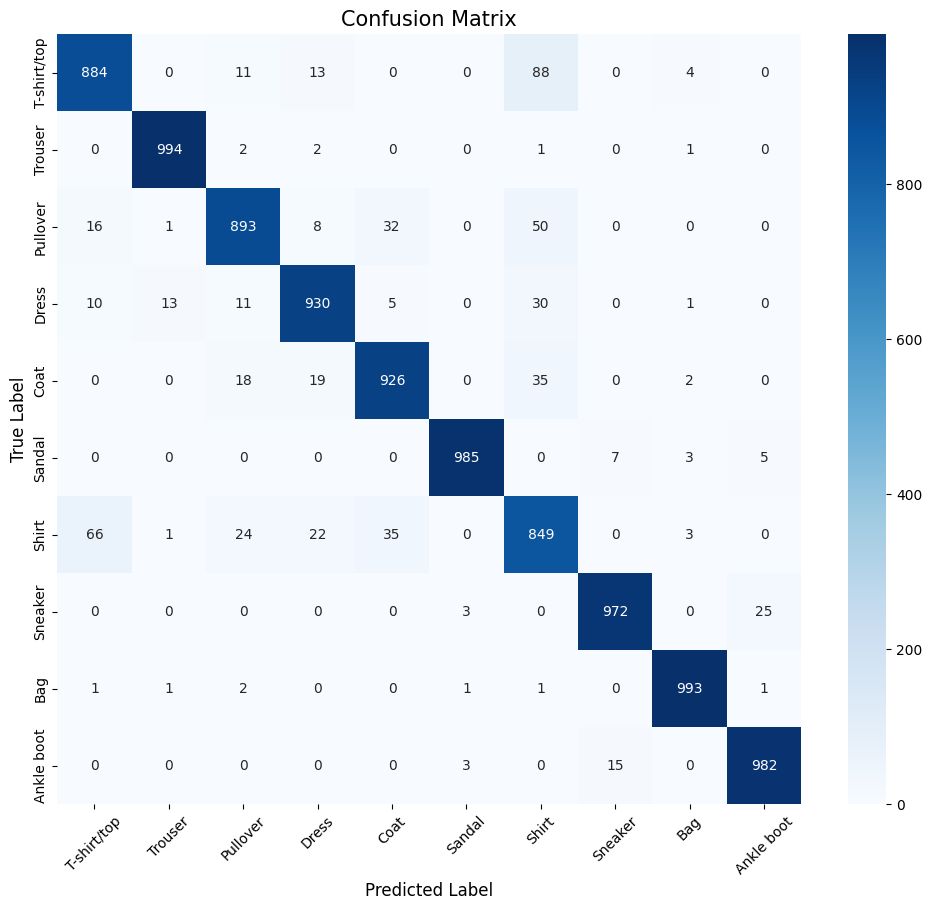

Classification Report:
               precision    recall  f1-score   support

 T-shirt/top       0.90      0.88      0.89      1000
     Trouser       0.98      0.99      0.99      1000
    Pullover       0.93      0.89      0.91      1000
       Dress       0.94      0.93      0.93      1000
        Coat       0.93      0.93      0.93      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.81      0.85      0.83      1000
     Sneaker       0.98      0.97      0.97      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.97      0.98      0.98      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Import metrics for evaluation.
model.eval()
# Set model to eval mode.
all_preds = []
# List to store all predictions.
all_labels = []
# List to store all true labels.
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Move data to device.
        outputs = model(inputs)
        # Forward pass.
        _, preds = torch.max(outputs, 1)
        # Get predicted class.
        all_preds.extend(preds.cpu().numpy())
        # Append predictions to list.
        all_labels.extend(labels.cpu().numpy())
        # Append true labels.
cm = confusion_matrix(all_labels, all_preds)
# Compute confusion matrix.
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)

plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.show()# Print confusion matrix.
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=target_names))
# Print detailed classification metrics.

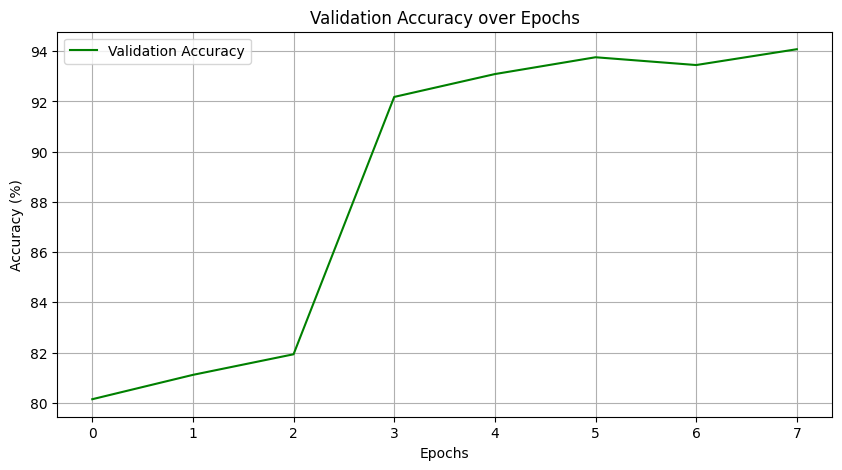

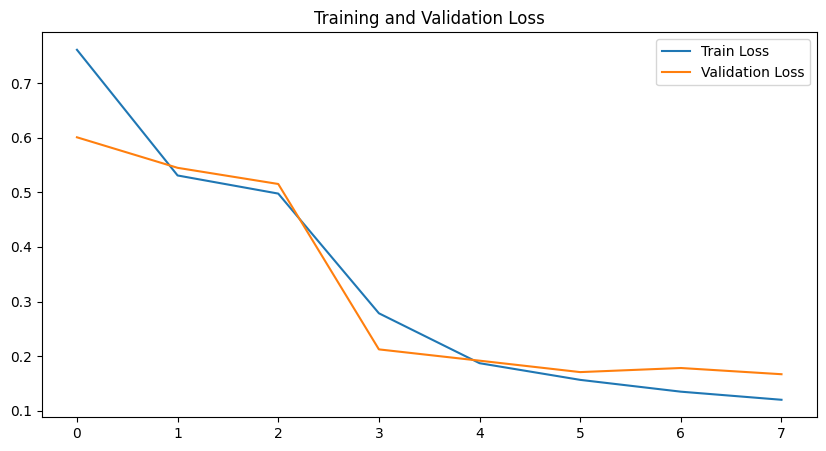

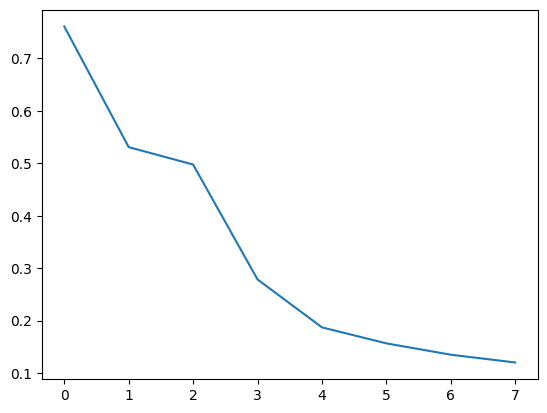

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(full_history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(full_history['train_loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(full_history['train_loss'])

### Comparison with Custom CNN
In this section, we compare the performance of the Transfer Learning approach (ResNet18) with the custom CNN model trained from scratch in Exercise 4 on the Fashion-MNIST dataset.

Analysis:
1. Accuracy Boost: The Transfer Learning approach outperformed the custom CNN by approximately 1.2%. While the custom CNN reached a respectable 91.82%, the pre-trained ResNet was able to break through this ceiling and reach ~93%.

 2. Feature Quality: The ResNet model leverages rich feature representations learned from millions of images in ImageNet. Even though Fashion-MNIST images are grayscale and smaller (requiring resizing), the low-level filters (edges, textures) and high-level abstractions learned by ResNet proved highly effective.

 3. Convergence: Transfer learning allowed the model to start with "knowledge," whereas the custom CNN had to learn all filters from random initialization.

  Conclusions:
  1. Effectiveness of Transfer Learning: Using a pre-trained model is highly effective even when the target domain (grayscale fashion items) differs slightly from the source domain (RGB natural images). The resizing to 224 X 224 allowed us to utilize the standard ResNet architecture without structural changes to the backbone.
  
  2. Training Efficiency: Freezing the backbone initially and then fine-tuning allowed for stable training. We avoided the instability that often comes with training deep networks from scratch on smaller datasets.
  
  3. Summary: The transition from a custom CNN to a standard industry-grade backbone like ResNet18 yielded a more robust model with higher accuracy. This demonstrates the power of Transfer Learning in achieving state-of-the-art results with relatively limited data or training time compared to training huge models from scratch.